# CycleGAN with Ignite

In this notebook we provide an implementation of [CycleGAN](https://arxiv.org/abs/1703.10593) and its training on "Horse 2 Zebra" dataset using Ignite.


### CycleGAN in a Nutshell

CycleGAN is unpaired image-to-image translation task from $A$ to $B$ and represented by two generative networks $G$ and $F$:
$$
\hat{y} = G(x) \in B,\text{ for } x \in A \\
\hat{x} = F(y) \in A,\text{ for } y \in B
$$

and two descriminators $D_x$ and $D_y$. Training of the networks is done by minimizing the loss is a sum of 3 components:
$$
\mathcal{L}(G, F, D_x, D_y) = \mathcal{L}_{GAN}(G, D_y, A, B) + \mathcal{L}_{GAN}(F, D_x, B, A) + \lambda \mathcal{L}_{cyc}(G, F)
$$
with GAN loss:
$$
\mathcal{L}_{GAN}(G, D, A, B) = \text{mean}_{x \in A}\left[ (D(G(x)) - 1)^2 \right]+ \text{mean}_{y \in B}\left[ (D(y) - 1)^2 \right]
$$
and forward and backward cycle consistency term:
$$
\mathcal{L}_{cyc}(G, F) = \text{mean}_{x \in A}\left[ |F(G(x)) - x|_1 \right] + \text{mean}_{y \in B}\left[ |G(F(y)) - y|_1 \right]
$$

Optionally, one can add identity loss terms. See [here](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/blob/master/docs/qa.md#what-is-the-identity-loss-322-373-362).

## Requirements

1) Let's download the dataset:

In [1]:
# !wget https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip -O/tmp/horse2zebra.zip
# !7z x /tmp/horse2zebra.zip -o/tmp/

2) Next we need to install `torchvision` and [nvidia/apex](https://github.com/NVIDIA/apex)

```python
# Torchvision:
pip install torchvision
# Apex:
git clone https://github.com/NVIDIA/apex && cd apex
pip install --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" .
# or 
pip install --no-cache-dir .
```

In [2]:
import random
import torch

seed = 17
random.seed(seed)
_ = torch.manual_seed(seed)

## Dataflow

Let's setup the datase

In [3]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class FilesDataset(Dataset):
    
    def __init__(self, path, extension="*.jpg"):
        self.path = Path(path)
        assert self.path.exists(), "Path '{}' is not found".format(path)
        self.images = list(self.path.rglob(extension))
        assert len(self.images) > 0, "No images with extension {} found at '{}'".format(extension, path)
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, i):
        return Image.open(self.images[i]).convert('RGB')

In [4]:
from pathlib import Path

root = Path("/tmp/horse2zebra")

train_A = FilesDataset(root / "trainA")
train_B = FilesDataset(root / "trainB")

test_A = FilesDataset(root / "testA") 
test_B = FilesDataset(root / "testB")

Some details on the datasets:

In [5]:
print("Dataset sizes: \ntrain A: {} | B: {}\ntest A: {} | B: {}\n\t".format(len(train_A), len(train_B), len(test_A), len(test_B)))

Dataset sizes: 
train A: 1067 | B: 1334
test A: 120 | B: 140
	


In [6]:
print("Train random image sizes (A): {}, {}, {}, {}".format(train_A[0].size, train_A[1].size, train_A[10].size, train_A[-1].size))

Train random image sizes (A): (256, 256), (256, 256), (256, 256), (256, 256)


In [7]:
print("Train random image sizes (B): {}, {}, {}, {}".format(train_B[0].size, train_B[1].size, train_B[10].size, train_B[-1].size))

Train random image sizes (B): (256, 256), (256, 256), (256, 256), (256, 256)


In [8]:
import matplotlib.pylab as plt
%matplotlib inline

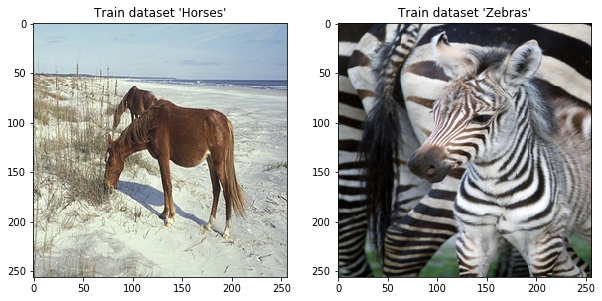

In [9]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Train dataset 'Horses'")
plt.imshow(train_A[10])
plt.subplot(122)
plt.title("Train dataset 'Zebras'")
plt.imshow(train_B[10])

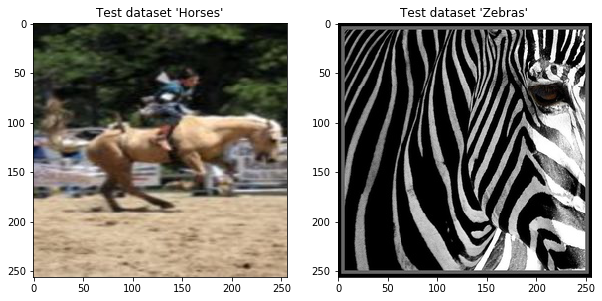

In [10]:
plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Test dataset 'Horses'")
plt.imshow(test_A[0])
plt.subplot(122)
plt.title("Test dataset 'Zebras'")
plt.imshow(test_B[0])

Let's create a dataset composed of random image pairs of datasets A and B

In [11]:
import random


class Image2ImageDataset(Dataset):
    
    def __init__(self, ds_a, ds_b):
        self.dataset_a = ds_a
        self.dataset_b = ds_b
    
    def __len__(self):
        return max(len(self.dataset_a), len(self.dataset_b))

    def __getitem__(self, i):
        dp_a = self.dataset_a[i % len(self.dataset_a)]
        j = random.randint(0, len(self.dataset_b) - 1)
        dp_b = self.dataset_b[j]
        return {
            'A': dp_a,
            'B': dp_b
        }


class TransformedDataset(Dataset):
        
    def __init__(self, ds, transform):
        self.dataset = ds
        self.transform = transform
        
    def __len__(self):
        return len(self.dataset)
    
    def __getitem__(self, i):
        return {k: self.transform(v) for k, v in self.dataset[i].items()}

In [12]:
train_ab_ds = Image2ImageDataset(train_A, train_B)
test_ab_ds = Image2ImageDataset(test_A, test_B)

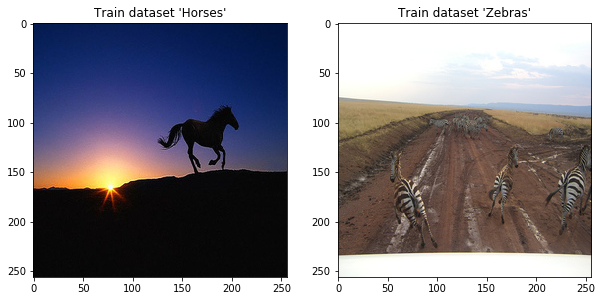

In [13]:
dp = train_ab_ds[20]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Train dataset 'Horses'")
plt.imshow(dp['A'])
plt.subplot(122)
plt.title("Train dataset 'Zebras'")
plt.imshow(dp['B'])

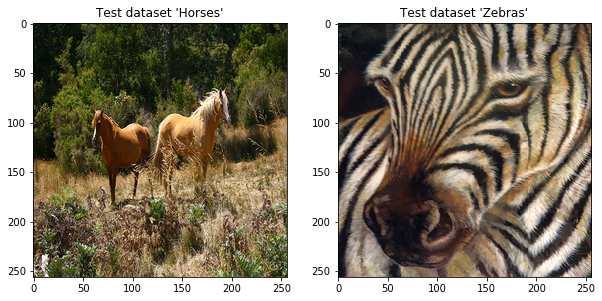

In [14]:
dp = test_ab_ds[20]

plt.figure(figsize=(10, 5))
plt.subplot(121)
plt.title("Test dataset 'Horses'")
plt.imshow(dp['A'])
plt.subplot(122)
plt.title("Test dataset 'Zebras'")
plt.imshow(dp['B'])

In [15]:
from torchvision.transforms import Compose, ColorJitter, RandomHorizontalFlip, ToTensor, Normalize


train_transform = Compose([
    RandomHorizontalFlip(),
    ColorJitter(),
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
transformed_train_ab_ds = TransformedDataset(train_ab_ds, transform=train_transform)

# Please select appropriate batch_size value according to your infrastructure
batch_size = 11
train_ab_loader = DataLoader(transformed_train_ab_ds, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True, num_workers=4)


test_transform = Compose([
    ToTensor(),
    Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
# transformed_test_ab_ds = TransformedDataset(test_ab_ds, transform=test_transform)
# batch_size = 10
# test_ab_loader = DataLoader(transformed_test_ab_ds, batch_size=batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

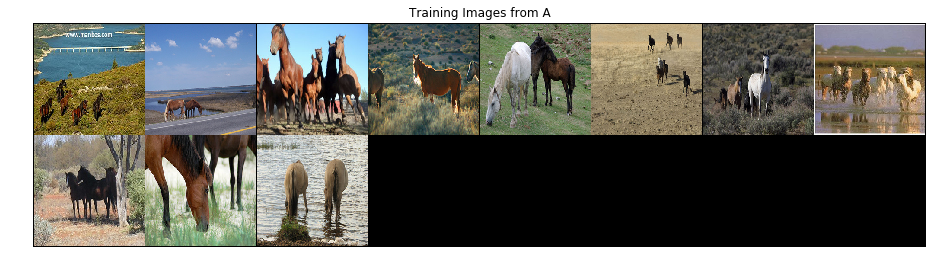

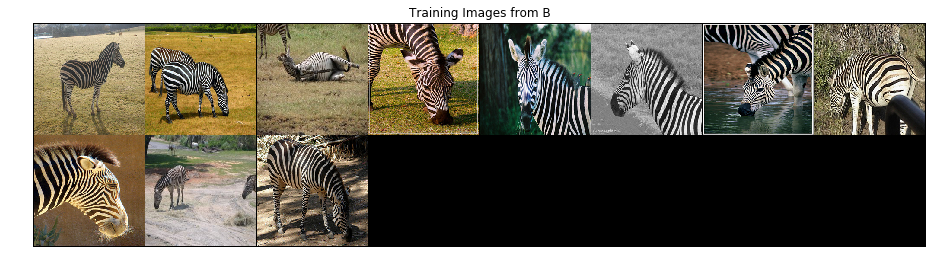

In [16]:
import torchvision.utils as vutils

# Plot some training images
real_batch = next(iter(train_ab_loader))

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Images from A")
plt.imshow( 
    vutils.make_grid(real_batch['A'][:64], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0))
)

plt.figure(figsize=(16, 8))
plt.axis("off")
plt.title("Training Images from B")
plt.imshow(
    vutils.make_grid(real_batch['B'][:64], padding=2, normalize=True).cpu().numpy().transpose((1, 2, 0))
)
real_batch = None
torch.cuda.empty_cache()

## Generator and Descriminator networks

- Generator network architecture contains 9 residual blocks
Using paper's notations:
```
c7s1-64,d128,d256,R256,R256,R256,R256,R256,R256,R256,R256,R256,u128,u64,c7s1-3,tanh
```
where `c7s1-k` denotes a 7x7 Convolution-InstanceNorm-ReLU layer with `k` filters and stride 1. `dk` denotes a 3x3 Convolution-InstanceNorm-ReLU layer  with `k` filters and stride 2. Reflection padding was used to reduce artifacts. `Rk` denotes a residual block that contains two 3x3 convolutional layers with the same number of filters on both layer. `uk` denotes a 3x3 fractional-strided-Convolution-InstanceNorm-ReLU layer with `k` filters and stride 1/2.

In [17]:
import torch
import torch.nn as nn


def get_conv_inorm_relu(in_planes, out_planes, kernel_size, stride, reflection_pad=True, with_relu=True):
    layers = []
    padding = (kernel_size - 1) // 2
    if reflection_pad:
        layers.append(nn.ReflectionPad2d(padding=padding))
        padding = 0
    layers += [
        nn.Conv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding),
        nn.InstanceNorm2d(out_planes, affine=False, track_running_stats=False),
    ]
    if with_relu:
        layers.append(nn.ReLU(inplace=True))
    return nn.Sequential(*layers)


def get_conv_transposed_inorm_relu(in_planes, out_planes, kernel_size, stride):
    return nn.Sequential(
        nn.ConvTranspose2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=1, output_padding=1),
        nn.InstanceNorm2d(out_planes, affine=False, track_running_stats=False),
        nn.ReLU(inplace=True)
    )


class ResidualBlock(nn.Module):
    
    def __init__(self, in_planes):
        super(ResidualBlock, self).__init__()
        self.conv1 = get_conv_inorm_relu(in_planes, in_planes, kernel_size=3, stride=1)
        self.conv2 = get_conv_inorm_relu(in_planes, in_planes, kernel_size=3, stride=1, with_relu=False)        

    def forward(self, x):
        residual = x
        x = self.conv1(x)
        x = self.conv2(x)        
        return x + residual


class Generator(nn.Module):
    
    def __init__(self):
        super(Generator, self).__init__()
        
        self.c7s1_64 = get_conv_inorm_relu(3, 64, kernel_size=7, stride=1)
        self.d128 = get_conv_inorm_relu(64, 128, kernel_size=3, stride=2, reflection_pad=False)
        self.d256 = get_conv_inorm_relu(128, 256, kernel_size=3, stride=2, reflection_pad=False)

        self.resnet9 = nn.Sequential(*[ResidualBlock(256) for i in range(9)])

        self.u128 = get_conv_transposed_inorm_relu(256, 128, kernel_size=3, stride=2)
        self.u64 = get_conv_transposed_inorm_relu(128, 64, kernel_size=3, stride=2)
        self.c7s1_3 = get_conv_inorm_relu(64, 3, kernel_size=7, stride=1, with_relu=False)
        # Replace instance norm by tanh activation
        self.c7s1_3[-1] = nn.Tanh()

    def forward(self, x):
        # Encoding
        x = self.c7s1_64(x)
        x = self.d128(x)
        x = self.d256(x)
        
        # 9 residual blocks
        x = self.resnet9(x)

        # Decoding
        x = self.u128(x)
        x = self.u64(x)
        y = self.c7s1_3(x)
        return y


Let's check the network:

In [18]:
x = torch.rand(4, 3, 256, 256)
g = Generator()
y = g(x)
y.shape

torch.Size([4, 3, 256, 256])

- Descriminator network is a PatchGAN (with receptive field 70x70):
```
C64-C128-C256-C512
```
where `Ck` denote a 4x4 Convolution-InstanceNorm-LeakyReLU layer with `k` filters and stride 2. After the last layer, 
a convolution to produce a 1-dimensional output is applied. No `InstanceNorm` for the first `C64` layer. Leaky ReLUs are with a slope of `0.2`. 

Good explanation is given in [this comment](https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix/issues/39#issuecomment-305575964) on what is a PatchGAN:
```
In fact, a "PatchGAN" is just a convnet! Or you could say all convnets are patchnets: the power of convnets is that they process each image patch identically and independently, which makes things very cheap (# params, time, memory), and, amazingly, turns out to work.

The difference between a PatchGAN and regular GAN discriminator is that rather the regular GAN maps from a 256x256 image to a single scalar output, which signifies "real" or "fake", whereas the PatchGAN maps from 256x256 to an NxN array of outputs X, where each X_ij signifies whether the patch ij in the image is real or fake. Which is patch ij in the input? Well, output X_ij is just a neuron in a convnet, and we can trace back its receptive field to see which input pixels it is sensitive to. In the CycleGAN architecture, the receptive fields of the discriminator turn out to be 70x70 patches in the input image!

This is all mathematically equivalent to if we had manually chopped up the image into 70x70 overlapping patches, run a regular discriminator over each patch, and averaged the results.

Maybe it would have been better if we called it a "Fully Convolutional GAN" like in FCNs... it's the same idea :)
```

In [19]:
def get_conv_inorm_lrelu(in_planes, out_planes, stride=2, negative_slope=0.2):
    return nn.Sequential(
        nn.Conv2d(in_planes, out_planes, kernel_size=4, stride=stride, padding=1),
        nn.InstanceNorm2d(out_planes, affine=False, track_running_stats=False),
        nn.LeakyReLU(negative_slope=negative_slope, inplace=True)
    )


class Descriminator(nn.Module):

    def __init__(self):
        super(Descriminator, self).__init__()
        self.c64 = nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1)
        self.relu = nn.LeakyReLU(0.2, inplace=True)
        self.c128 = get_conv_inorm_lrelu(64, 128)
        self.c256 = get_conv_inorm_lrelu(128, 256)
        self.c512 = get_conv_inorm_lrelu(256, 512, stride=1)
        self.last_conv = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

    def forward(self, x):
        x = self.c64(x)
        x = self.relu(x)

        x = self.c128(x)
        x = self.c256(x)
        x = self.c512(x)
        y = self.last_conv(x)
        return y


Let's check the network:

In [20]:
x = torch.rand(4, 3, 256, 256)
d = Descriminator()
y = d(x)
y.shape

torch.Size([4, 1, 30, 30])

According to the paper, the weights are initialized from a Gaussian distribution $\mathcal{N}(0,0.02)$

In [21]:
def init_weights(module):
    assert isinstance(module, nn.Module)
    if hasattr(module, "weight") and module.weight is not None:
        torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
    if hasattr(module, "bias") and module.bias is not None:
        torch.nn.init.constant_(module.bias, 0.0)
    for c in module.children():
        init_weights(c)

In [22]:
g = None; d = None

## Networks training

In [23]:
assert torch.backends.cudnn.enabled, "NVIDIA/Apex:Amp requires cudnn backend to be enabled."
torch.backends.cudnn.benchmark = True

In [24]:
device = "cuda"

generator_A2B = Generator().to(device)
init_weights(generator_A2B)

descriminator_B = Descriminator().to(device)
init_weights(descriminator_B)

generator_B2A = Generator().to(device)
init_weights(generator_B2A)
descriminator_A = Descriminator().to(device)
init_weights(descriminator_A)

Similarly, we train the networks from scratch, with a learning rate of `0.0002`.

In [25]:
from itertools import chain
import torch.optim as optim

lr = 0.0002
beta1 = 0.5

optimizer_G = optim.Adam(chain(generator_A2B.parameters(), generator_B2A.parameters()), lr=lr, betas=(beta1, 0.999))
optimizer_D = optim.Adam(chain(descriminator_A.parameters(), descriminator_B.parameters()), lr=lr, betas=(beta1, 0.999))

Let's define some helper functions:
- to turn on/off gradients

In [26]:
def toggle_grad(model, on_or_off):
    # https://github.com/ajbrock/BigGAN-PyTorch/blob/master/utils.py#L674
    for param in model.parameters():
        param.requires_grad = on_or_off


try:
    from apex import amp
except ImportError:
    raise ImportError("Please install apex from https://www.github.com/nvidia/apex to run this example.")


# Initialize Amp
models, optimizers = amp.initialize([generator_A2B, generator_B2A, descriminator_A, descriminator_B], 
                                    [optimizer_G, optimizer_D],
                                    opt_level="O2", num_losses=2)

generator_A2B, generator_B2A, descriminator_A, descriminator_B = models
optimizer_G, optimizer_D = optimizers

Selected optimization level O2:  FP16 training with FP32 batchnorm and FP32 master weights.

Defaults for this optimization level are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O2
cast_model_type        : torch.float16
patch_torch_functions  : False
keep_batchnorm_fp32    : True
master_weights         : True
loss_scale             : dynamic


### Fake images buffer trick

According to the paper, to reduce model oscillation and the discriminators are updated using a history of generated images rather than the ones produced by the latest generators. There is an image buffer that stores the X previously created images.

In [27]:
buffer_size = 50
fake_a_buffer = []
fake_b_buffer = []


def buffer_insert_and_get(buffer, batch):
    output_batch = []
    for b in batch:
        b = b.unsqueeze(0)
        # if buffer is not fully filled:
        if len(buffer) < buffer_size:
            output_batch.append(b)
            buffer.append(b.cpu())
        elif random.uniform(0, 1) > 0.5:
            # Add newly created image into the buffer and put ont from the buffer into the output
            random_index = random.randint(0, buffer_size - 1)            
            output_batch.append(buffer[random_index].clone().to(device))
            buffer[random_index] = b.cpu()
        else:
            output_batch.append(b)
    return torch.cat(output_batch, dim=0)

Next, let's define a single iteration via `update_fn`. This function is then is used by `ignite.engine.Engine` to update models while running over the input data.

As suggested, we divide the objective by 2 while optimizing D, which slows down the rate at which D learns, relative to the rate of G. 

According to the paper,:
- generator (A or B) is trained  minimize $\text{mean}_{x}[(D(G(x)) − 1)^2]$ and cycle loss $\text{mean}_{x \in A}\left[ |F(G(x)) - x|_1 \right]$
- descriminator (A or B) is trained to minimize $\text{mean}_{y}[(D(y) − 1)^2] + \text{mean}_{x}[D(G(x))^2]$.

In [28]:
from ignite.utils import convert_tensor
import torch.nn.functional as F


lambda_value = 10.0


def descriminator_forward_pass(descriminator, batch_real, batch_fake, fake_buffer):
    decision_real = descriminator(batch_real)
    batch_fake = buffer_insert_and_get(fake_buffer, batch_fake)
    batch_fake = batch_fake.detach()        
    decision_fake = descriminator(batch_fake)
    return decision_real, decision_fake


def loss_generator(batch_decision, batch_real, batch_rec, lambda_value):
    # loss gan
    target = torch.ones_like(batch_decision)
    loss_gan = F.mse_loss(batch_decision, target)
    # loss cycle
    loss_cycle = F.l1_loss(batch_rec, batch_real) * lambda_value    
    return loss_gan + loss_cycle


def loss_descriminator(decision_real, decision_fake):
    # loss = mean (D_b(y) − 1)^2 + mean D_b(G(x))^2    
    loss = F.mse_loss(decision_fake, torch.zeros_like(decision_fake))
    loss += F.mse_loss(decision_real, torch.ones_like(decision_real))
    return loss


def update_fn(engine, batch):
    generator_A2B.train()
    generator_B2A.train()
    descriminator_A.train()
    descriminator_B.train()    

    real_a = convert_tensor(batch['A'], device=device, non_blocking=True)
    real_b = convert_tensor(batch['B'], device=device, non_blocking=True)
    
    fake_b = generator_A2B(real_a)
    rec_a = generator_B2A(fake_b)
    fake_a = generator_B2A(real_b)
    rec_b = generator_A2B(fake_a)
    decision_fake_a = descriminator_A(fake_a)
    decision_fake_b = descriminator_B(fake_b)

    # Disable grads computation for the descriminators:
    toggle_grad(descriminator_A, False)
    toggle_grad(descriminator_B, False)    
    
    # Compute loss for generators and update generators
    # loss_a2b = GAN loss: mean (D_b(G(x)) − 1)^2 + Forward cycle loss: || F(G(x)) - x ||_1    
    loss_a2b = loss_generator(decision_fake_b, real_a, rec_a, lambda_value)    

    # loss_b2a = GAN loss: mean (D_a(F(x)) − 1)^2 + Backward cycle loss: || G(F(y)) - y ||_1
    loss_b2a = loss_generator(decision_fake_a, real_b, rec_b, lambda_value)

    # total generators loss:
    loss_generators = loss_a2b + loss_b2a

    optimizer_G.zero_grad()    
    with amp.scale_loss(loss_generators, optimizer_G, loss_id=0) as scaled_loss:
        scaled_loss.backward()
    optimizer_G.step()

    decision_fake_a = rec_a = decision_fake_b = rec_b = None
    
    # Enable grads computation for the descriminators:
    toggle_grad(descriminator_A, True)
    toggle_grad(descriminator_B, True)    

    decision_real_a, decision_fake_a = descriminator_forward_pass(descriminator_A, real_a, fake_a, fake_a_buffer)    
    decision_real_b, decision_fake_b = descriminator_forward_pass(descriminator_B, real_b, fake_b, fake_b_buffer)    
    # Compute loss for descriminators and update descriminators
    # loss_a = mean (D_a(y) − 1)^2 + mean D_a(F(x))^2
    loss_a = loss_descriminator(decision_real_a, decision_fake_a)

    # loss_b = mean (D_b(y) − 1)^2 + mean D_b(G(x))^2
    loss_b = loss_descriminator(decision_real_b, decision_fake_b)
    
    # total descriminators loss:
    loss_descriminators = 0.5 * (loss_a + loss_b)
    
    optimizer_D.zero_grad()
    with amp.scale_loss(loss_descriminators, optimizer_D, loss_id=1) as scaled_loss:
        scaled_loss.backward()
    optimizer_D.step()
    
    return {
        "loss_generators": loss_generators.item(),
        "loss_generator_a2b": loss_a2b.item(),
        "loss_generator_b2a": loss_b2a.item(),
        "loss_descriminators": loss_descriminators.item(),
        "loss_descriminator_a": loss_a.item(),
        "loss_descriminator_b": loss_b.item(),
    }
    

Let's check `update_fn`

In [29]:
real_batch = next(iter(train_ab_loader))

res = update_fn(engine=None, batch=real_batch)

real_batch = None
torch.cuda.empty_cache()

res

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0


{'loss_generators': 15.258794784545898,
 'loss_generator_a2b': 7.270878791809082,
 'loss_generator_b2a': 7.987916469573975,
 'loss_descriminators': 3.229292869567871,
 'loss_descriminator_a': 3.3171353340148926,
 'loss_descriminator_b': 3.1414504051208496}

Now let's define a trainer and add some practical handlers:
- log to tensorboard: losses, lr, generated images
- progress bar
- models/optimizers checkpointing

In [30]:
from ignite.engine import Engine, Events
from ignite.metrics import RunningAverage

from ignite.contrib.handlers import TensorboardLogger
from ignite.contrib.handlers.tensorboard_logger import OutputHandler, OptimizerParamsHandler

In [31]:
from functools import partial


trainer = Engine(update_fn)

metric_names = [
    'loss_descriminators', 
    'loss_generators', 
    'loss_descriminator_a',
    'loss_descriminator_b',
    'loss_generator_a2b',
    'loss_generator_b2a'    
]

def output_transform(out, name):
    return out[name]

for name in metric_names:
    # here we cannot use lambdas as they do not store argument `name`
    RunningAverage(output_transform=partial(output_transform, name=name)).attach(trainer, name)


In [32]:
from datetime import datetime

exp_name = datetime.now().strftime("%Y%m%d-%H%M%S")
tb_logger = TensorboardLogger(log_dir="/tmp/cycle_gan_horse2zebra_tb_logs/{}".format(exp_name))

tb_logger.attach(trainer, 
                 log_handler=OutputHandler('training', metric_names), 
                 event_name=Events.ITERATION_COMPLETED)

print("Experiment name: ", exp_name)

Experiment name:  20190425-210241


Let's create an evaluator to inference on train/test images and log the generated images to Tensorboard:

In [33]:
from ignite.engine import Engine


def evaluate_fn(engine, batch):
    generator_A2B.eval()
    generator_B2A.eval()    
    with torch.no_grad():
        real_a = convert_tensor(batch['A'], device=device, non_blocking=True)
        real_b = convert_tensor(batch['B'], device=device, non_blocking=True)
        
        fake_b = generator_A2B(real_a)
        rec_a = generator_B2A(fake_b)

        fake_a = generator_B2A(real_b)
        rec_b = generator_A2B(fake_a)
        
    return {
        'real_a': real_a,
        'real_b': real_b,
        'fake_a': fake_a,
        'fake_b': fake_b,
        'rec_a': rec_a,
        'rec_b': rec_b,        
    }


evaluator = Engine(evaluate_fn)

In [34]:
from torch.utils.data import Subset

eval_batch_size = 5

train_random_indices = [random.randint(0, len(train_ab_ds) - 1) for _ in range(eval_batch_size)]
small_train_ds = Subset(train_ab_ds, train_random_indices)
small_train_ds = TransformedDataset(small_train_ds, transform=test_transform)

test_random_indices = [random.randint(0, len(test_ab_ds) - 1) for _ in range(eval_batch_size)]
small_test_ds = Subset(test_ab_ds, test_random_indices)
small_test_ds = TransformedDataset(small_test_ds, transform=test_transform)

eval_train_loader = DataLoader(small_train_ds, batch_size=eval_batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)
eval_test_loader = DataLoader(small_test_ds, batch_size=eval_batch_size, shuffle=False, drop_last=False, pin_memory=True, num_workers=4)

In [35]:
@trainer.on(Events.EPOCH_STARTED)
def run_evaluation(engine):
    evaluator.run(eval_train_loader)
    evaluator.run(eval_test_loader)


def log_generated_images(engine, logger, event_name):

    tag = "Train" if engine.state.dataloader == eval_train_loader else "Test"
    output = engine.state.output
    state = trainer.state
    global_step = state.get_event_attrib_value(event_name)

    # create a grid:
    # [real a1, real a2, ...]
    # [fake a1, fake a2, ...]
    # [rec a1, rec a2, ...]
    
    s = output['real_a'].shape[0]
    res_a = vutils.make_grid(torch.cat([
        output['real_a'],
        output['fake_b'],
        output['rec_a'],
    ]), padding=2, normalize=True, nrow=s).cpu()

    logger.writer.add_image(tag="{} Horses2Zebras (real, fake, rec)".format(tag), 
                            img_tensor=res_a, global_step=global_step, dataformats='CHW')

    s = output['real_b'].shape[0]
    res_b = vutils.make_grid(torch.cat([
        output['real_b'],
        output['fake_a'],
        output['rec_b'],
    ]), padding=2, normalize=True, nrow=s).cpu()
    logger.writer.add_image(tag="{} Zebras2Horses (real, fake, rec)".format(tag), 
                            img_tensor=res_b, global_step=global_step, dataformats='CHW')

    
tb_logger.attach(evaluator,
                 log_handler=log_generated_images, 
                 event_name=Events.COMPLETED)

We also follow suggested lr scheduling: the same learning rate for the first 100 epochs and linearly decay the rate to zero over the next 100 epochs.

In [36]:
from ignite.contrib.handlers import PiecewiseLinear, ParamGroupScheduler

lr = 0.0002

milestones_values = [
    (0, lr),
    (100, lr),
    (200, 0.0)
]
gen_lr_scheduler = PiecewiseLinear(optimizer_D, param_name='lr', milestones_values=milestones_values)
desc_lr_scheduler = PiecewiseLinear(optimizer_G, param_name='lr', milestones_values=milestones_values)

lr_scheduler = ParamGroupScheduler([gen_lr_scheduler, desc_lr_scheduler], 
                                   names=['gen_lr_scheduler', 'desc_lr_scheduler'])

trainer.add_event_handler(Events.EPOCH_STARTED, lr_scheduler)


tb_logger.attach(trainer,
                 log_handler=OptimizerParamsHandler(optimizer_G, "lr"), 
                 event_name=Events.EPOCH_STARTED)

Let's setup models/optimizers checkpointing:

In [37]:
from ignite.handlers import ModelCheckpoint, TerminateOnNan

In [38]:
!mkdir "/tmp/cycle_gan_checkpoints"

from ignite.handlers import ModelCheckpoint, TerminateOnNan


checkpoint_handler = ModelCheckpoint(dirname="/tmp/cycle_gan_checkpoints",
                                     filename_prefix="checkpoint",
                                     save_interval=500)

to_save = {
    "generator_A2B": generator_A2B,
    "descriminator_B": descriminator_B,
    "generator_B2A": generator_B2A,
    "descriminator_A": descriminator_A,
    
    "optimizer_G": optimizer_G,
    "optimizer_D": optimizer_D,
}

trainer.add_event_handler(Events.ITERATION_COMPLETED, checkpoint_handler, to_save)
trainer.add_event_handler(Events.ITERATION_COMPLETED, TerminateOnNan())

mkdir: cannot create directory ‘/tmp/cycle_gan_checkpoints’: File exists


In [39]:
from ignite.contrib.handlers import ProgressBar

# Iteration-wise progress bar
ProgressBar(bar_format="").attach(trainer)
# Epoch-wise progress bar with display of training losses
ProgressBar(persist=True, bar_format="").attach(trainer, metric_names=['loss_descriminators', 'loss_generators'], 
                                                event_name=Events.EPOCH_COMPLETED, closing_event_name=Events.COMPLETED)

/opt/conda/lib/python3.7/site-packages/tqdm/autonotebook/__init__.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  " (e.g. in jupyter console)", TqdmExperimentalWarning)


In [ ]:
trainer.run(train_ab_loader, max_epochs=200)

Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 1 reducing loss scale to 32768.0


Gradient overflow.  Skipping step, loss scaler 1 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 1 reducing loss scale to 8192.0


## Now, we can launch tensorboard in a terminal and monitor the training:
```
tensorboard --logdir=/tmp/cycle_gan_horse2zebra_tb_logs
```

In [ ]:
tb_logger.close()